# Project 2: Data mining competition -- Bianca De Saedeleer

For both challenges, data sets containing a number of features, observations and the accompanying classes or labels are provided. Since the aim of this competition is to predict, supervised learning methods will be used to solve these prediction problems. Unsupervised methods will not be used here, because they tend to be more subjective and provide less stable outcomes (James et al., 2013).

## Challenge 1: Cell type prediction


In [32]:
import pandas as pd 
import numpy as np

from sklearn import svm
from sklearn.svm import SVC
from sklearn.svm import SVR
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, mean_squared_error
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,  GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz as export
from sklearn.utils import resample
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
plt.style.use('seaborn-white')
%matplotlib inline

### 1. Exploration and preprocessing of the data

The training data set consists of 20 000 observations, 27 features and 55 classes of which 1 class is discarded. This is class 31, which will be removed from the data.

In [33]:
# Read in the data
MC_train = pd.read_csv('CTP_train_data.csv', index_col=0)
X_test = pd.read_csv('CTP_test_data.csv', index_col=0)
classes = pd.read_csv('class_info.csv')
MC_train.head()
#MC_test.head()
#print(classes)

#Label 31 =  discarded, remove this from the data
idx = MC_train['label']==31
MC_train = MC_train[-idx]

MC = MC_train.drop(['label'], axis=1)
labels = MC_train['label'].values

#y = LabelEncoder().fit_transform(labels), shouldn't make labels of your classes, because some classes are missing and this
#will introduce errors
y = pd.DataFrame(labels,dtype=int)
#print(y)

In [34]:
MC_train['label'].value_counts()

11    6294
12    2660
22    1558
43    1155
24    1116
3      874
16     788
15     636
55     603
8      590
17     452
18     367
13     302
26     274
5      269
19     269
25     266
27     205
45     170
20     137
54      93
53      83
36      76
14      74
30      50
32      48
9       47
39      45
7       41
44      38
0       36
57      35
33      30
56      30
48      21
34      21
28      21
6       20
41      19
2       16
29      15
38      15
1       13
35      13
23      12
49      12
40       9
47       8
37       8
21       5
46       5
10       1
4        1
50       1
Name: label, dtype: int64

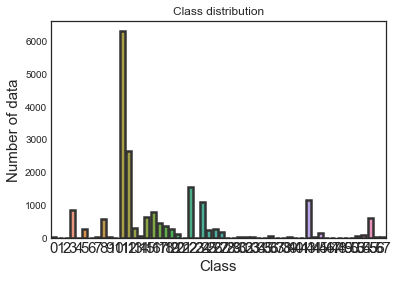

In [35]:
#Following snippet is from https://github.com/msahamed/handle_imabalnce_class/blob/master/imbalance_datasets_machine_learning.ipynb
#which provides a nice visualization of the imbalance in the data set
label_count = MC_train.groupby('label', as_index = False).count()
class_name = list(label_count['label'])
count = list(label_count['2'])
index = np.arange(len(class_name))

sns.barplot(x=class_name, y=count, linewidth=2.5, errcolor=".2", edgecolor=".2")
plt.xlabel('Class', fontsize=15)
plt.ylabel('Number of data', fontsize=15)
plt.xticks(index, class_name, fontsize=15)
plt.title('Class distribution')
plt.show()

The data set is imbalanced, which will lead to low performance, because classifiers tend to maximize their accuracy by correctly classifying the dominant classes, leading to bad predictions for the minority classes (Sejdic & Falk, 2018). Splitting the data is performed in order to get a set for tuning the hyperparameters. The data should be split in a stratified manner, since some classes don't contain at least 2 observations, stratified splits result in an error. 

Oversampling the minority classes can help to correct the bias in imbalanced data sets. The <code>RandomOverSampler()</code> function of [imblearn](https://imbalanced-learn.org/en/stable/index.html) will be used. This is rather a naive approach that resamples the data with replacement and thus duplicating original samples. The SMOTE and ADASYN methods might give better results since they generate new samples by interpolation. However, these methods are based on the k-Nearest Neighbors classifier, because some classes in our data only contain 1 observation, these methods can't be used. Oversampling should be done after splitting the data into a training and validation set, otherwise information from the validation set will leak into the training set, inducing overfitting. An illustration of the effect of oversampling before or after splitting your data can be found [here](https://beckernick.github.io/oversampling-modeling/).

An alternative approach to handle imbalance, is to undersample the majority classes or to introduce class weights in the classification model (Sejdic & Falk, 2018). Other inventive and interesting combinations that deal with imbalanced data can be found [here](https://towardsdatascience.com/working-with-highly-imbalanced-datasets-in-machine-learning-projects-c70c5f2a7b16).

In [36]:
X_tr, X_tu, y_tr, y_tu = train_test_split(MC, np.ravel(y), train_size=0.8, random_state=5)

ros = RandomOverSampler(ratio='auto', random_state=5) #'auto' means not oversampling from the majority classes
X_tr_res, y_tr_res = ros.fit_sample(X_tr, y_tr)
X_tu_res, y_tu_res = ros.fit_sample(X_tu, y_tu)

C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [37]:
#Remove class 31
d = y_tr_res==31
X_tr_res = X_tr_res[~d]
y_tr_res = y_tr_res[~d]

e = y_tu_res==31
X_tu_res = X_tu_res[~e]
y_tu_res = y_tu_res[~e]

In [38]:
#Standardization of the data
scaler = StandardScaler()
scaler.fit(X_tr_res)
X_tr = scaler.transform(X_tr_res)
X_tu = scaler.transform(X_tu_res)
X_te = scaler.transform(X_test)

### 2. Chosing and comparing models
In class, following overview is provided
<img src="./TableOverview.png" style="width:75%">

Since the used dataset contains 27 variables and 20 000 observations, the use of a SVM or RF is more suitable for this problem.
To handle the imbalance of the data, a [combination of different techniques](https://elitedatascience.com/imbalanced-classes) will be executed and compared.

#### 2.1 Building a model using SVM
Based on a cheat sheet of sklearn Support Vector Machines will be used first to try to predict the classes.

<img src="./cheatsheet.png" style="width:75%">

First, the <code>SGDClassifier()</code> is used, then <code>SVC()</code> using the linear and the rbf kernel are compared. A very brief discussion on the "class_weight" parameter can be found in section <b>2.6 Last attempt to improve the model</b>. For the linear kernel, the hyperparameter C is optimized by a more naive approach. To tune the hyperparameters C and $\gamma$ of the rbf kernel, a randomized grid search (more efficient, Bergsta & Bengio (2012)) is performed which took almost 4 days. The best way to compare the linear and radial kernel should be to perform the randomized grid search to both kernels simultaneously, however, due to computational infeasibility, this is not executed now.

Since SGD does not give better results than the SVC functions and the codes are similar to each other, only the code for using <code>SVC()</code> is shown.

In [ ]:
#SVC with linear kernel
acc_svc = np.zeros(10)
i=0

# Simplified way to tune the hyperparameter C
for c in np.logspace(-4,4,10): 
    svc = SVC(kernel='linear', C=c, class_weight='balanced', decision_function_shape='ovo', verbose=100) #ovo always used for multiclass
    svc.fit(X_tr,y_tr_res)
    y_pred = svc.predict(X_tu)
    acc_svc[i] = accuracy_score(y_tu_res,y_pred)
    i+=1
    fig, ax = plt.subplots()
    
ax.scatter(np.logspace(-4,4,10), acc_svc, c='r')
ax.set_xlabel('C', size=18)
ax.set_ylabel('Accuracy', size=18)
ax.set_xscale('log')
ax.set_xlim(10**(-5),10**5)
ax.set_ylim(0.50,0.95)
ax.legend()
plt.show()

print('Performance of Linear SVM: ' + str(acc_svc.max()))

Best value for $C = 0.001$.

In [ ]:
#SVC with rbf kernel
n_iters = np.arange(2,10,2)
acc_rs = np.zeros(4)
pars = {'C': np.logspace(-3,3,10), 'gamma': np.logspace(-3, 3, 10)}
i=0
for n_iter in n_iters: 
    svc_rs = RandomizedSearchCV(SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovo'), param_distributions=pars, cv=4, n_iter=n_iter, verbose=100)
    svc_rs.fit(X_tr,y_tr_res)
    y_pred = svc_rs.predict(X_tu)
    acc_rs[i] = accuracy_score(y_tu_res,y_pred)
    i+=1

In [ ]:
print('Accuracy SVM with rbf-kernel after randomized grid search: ' + str(acc_rs))
print('Optimal parameter values are: ' +str(svc_rs.best_params_))

fig, ax = plt.subplots()
ax.scatter(np.arange(2,10,2), acc_rs, c='r')
ax.set_xlabel('# trials', size=18)
ax.set_ylabel('Accuracy', size=18)
ax.set_xlim(0,10)
ax.set_ylim(0.1,1)
ax.legend()
plt.show()

The obtained accuracies of the SVM with rbf-kernel after randomized grid search are 0.64431829, 0.25180255, 0.01960784 and 0.23421748. The randomized grid search results in the optimal parameter values $ C = 215.44346900318823$ and $\gamma = 0.46415888336127775$.


In [39]:
#Train optimized SVM model with linear kernel
clf_lin = svm.SVC(kernel='linear', C=0.001, class_weight='balanced', decision_function_shape='ovo', verbose=100) 
clf_lin.fit(X_tr, y_tr_res)
pred_lin = clf_lin.predict(X_tu)
acc_lin = accuracy_score(y_tu_res,pred_lin)
f1_lin = f1_score(y_tu_res, pred_lin, average='micro')
print('Performance of Linear SVM: ' +str(acc_lin))
print('F1 score of Linear SVM: ' + str(f1_lin))

[LibSVM]Performance of Linear SVM: 0.7277576588039542
F1 score of Linear SVM: 0.7277576588039542


In [21]:
#Train optimized SVM model with radial kernel
clf_rbf = svm.SVC(kernel='rbf', C=215.44346900318823, gamma=0.46415888336127775, class_weight='balanced', verbose=100, decision_function_shape='ovo')
clf_rbf.fit(X_tr, y_tr_res) 
pred_rbf = clf_rbf.predict(X_tu)
acc_rbf = accuracy_score(y_tu_res,pred_rbf)
f1_rbf = f1_score(y_tu_res, pred_rbf, average='micro')
print('Performance of RBF SVM: ' +str(acc_rbf))
print('F1 score of RBF SVM: ' + str(f1_rbf))

[LibSVM]Performance of RBF SVM: 0.23421748066947246
F1 score of RBF SVM: 0.23421748066947246


#### 2.2 Prediction on the test data using SVM
The trained models are now used to predict the classes of the test data.

In [ ]:
submis = pd.read_csv('sample_submission.csv', index_col=0)

pred_te = clf_lin.predict(X_te)
submis['label'] = pred_te
#print(submis)
submis.to_csv('SVCweightlinSubmission.csv', encoding='utf-8', index=True)

pred_te = clf_rbf.predict(X_te)
submis['label'] = pred_te
#print(submis)
submis.to_csv('SVCweightrbfSubmission.csv', encoding='utf-8', index=True)

The predictions using the rbf kernel get a score of 0.78994 on kaggle, the linear kernel results in a score of 0.85479. The SVM with linear kernel performs better, but its performance is still under the baseline.

#### 2.3 Building a model using Random Forests
In the following part, Random Forests are used to build an alternative model in order to (hopefully) obtain a better prediction score. The use of Random Forests avoids overfitting and provides an uncorrelated approach leading to less variance and more reliable results (James et al., 2013). RF is also more suitable for learning from very imbalanced data, but might be biased on the majority class.

In [ ]:
#Tuning the hyperparameters of RF model using randomized grid search
n_trees = 100
n_iters = np.arange(2,22,2)
acc_rf = np.zeros(n_trees)
param = {"max_features": np.arange(1,X_tr.shape[1]), "n_estimators": np.arange(1, n_trees)}
i=0
for n_iter in n_iters: 
    svc_rf = RandomizedSearchCV(RandomForestClassifier(bootstrap=True), param_distributions=param, n_iter=n_iter , verbose=100, scoring='f1_micro')
    svc_rf.fit(X_tr,y_tr_res)
    y_pred = svc_rf.predict(X_tu)
    acc_rf[i] = accuracy_score(y_tu_res,y_pred)
    i+=1
    
print('Maximal accuracy Random Forests: ' + str(acc_rf.max()))
print('Best parameters: {}'.format(svc_rf.best_params_))

The randomized grid search gives following best values for the hyperparameters: 
n_estimators = 76 and max_features = 5.

In [22]:
#Train optimized RF model
rf = RandomForestClassifier(n_estimators=76, max_features=5, bootstrap=True)
rf.fit(X_tr, y_tr_res)
pred_rf = rf.predict(X_tu)
acc_rf = accuracy_score(y_tu_res,pred_rf)
f1_rf = f1_score(y_tu_res, pred_rf, average='micro')
print('Performance of RF: ' +str(acc_rf))
print('F1 score of RF: ' + str(f1_rf))

Performance of RF: 0.591514143094842
F1 score of RF: 0.591514143094842


#### 2.4 Prediction on the test data using RF

In [ ]:
#Make predictions on test data
submis = pd.read_csv('sample_submission.csv', index_col=0)
pred_te = rf.predict(X_te)
submis['label'] = pred_te
#print(submis)
submis.to_csv('RF76Submission.csv', encoding='utf-8', index=True)

This model obtains a score of 0.89896 on kaggle, which is still under the baseline, but already an improvement considering the SVM models.

#### 2.5 Bagging and Boosting
The low predictive force of the used models can be due to over- or underfitting. Here, bagging and boosting will be utilized in combination with the optimized RF model from previously: <code>rf = RandomForestClassifier(n_estimators=76, max_features=5, bootstrap=True)</code>. 

Bagging can be used to tackle overfitting as it decreases the variance of the predictions, but it won't lead to an increase of predictive force. Boosting, on the other hand, handles underfitting by lowering the bias and therefore improving the predicition accuracy. Further details on the differences between boosting and bagging can be found [here](https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning).

First, bagging is tried out using the default <code>BaggingClassifier()</code>.

In [23]:
#Bagging (default) of RF model
rf = RandomForestClassifier(n_estimators=76, max_features=5, bootstrap=True)
bagging = BaggingClassifier(rf, random_state=5, verbose=100)
bagging.fit(X_tr, y_tr_res)
pred_bg = bagging.predict(X_tu)
acc_bg = accuracy_score(y_tu_res,pred_bg)
f1_bg = f1_score(y_tu_res, pred_bg, average='micro')
print('Performance of bagging: ' +str(acc_bg))
print('F1 score of bagging: ' + str(f1_bg))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Building estimator 1 of 10 for this parallel run (total 10)...
Building estimator 2 of 10 for this parallel run (total 10)...
Building estimator 3 of 10 for this parallel run (total 10)...
Building estimator 4 of 10 for this parallel run (total 10)...
Building estimator 5 of 10 for this parallel run (total 10)...
Building estimator 6 of 10 for this parallel run (total 10)...
Building estimator 7 of 10 for this parallel run (total 10)...
Building estimator 8 of 10 for this parallel run (total 10)...
Building estimator 9 of 10 for this parallel run (total 10)...
Building estimator 10 of 10 for this parallel run (total 10)...
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   34

In [ ]:
#Make predictions on test data using bagged RF
submis = pd.read_csv('sample_submission.csv', index_col=0)
pred_te = bagging.predict(X_te)
submis['label'] = pred_te
#print(submis)
submis.to_csv('BaggingSubmission.csv', encoding='utf-8', index=True)

As expected, these predicitions lead to the same score (0.89896 on kaggle) as the RF model individually. Therefore, I'm not going further with bagging and I won't tune its hyperparameters as this takes up some days. Next, the <code>AdaBoostClassifier()</code> is used to perform boosting. As (again) finetuning the parameters takes quite some time, a limited (n_trees=10, corresponding to 378 fits) grid search using <code>GridSearchCV()</code> is performed (as a randomized grid search takes even more time).

In [ ]:
#Boosting and finetuning the parameters
n_trees = 10
param_grid = {"base_estimator__max_leaf_nodes" : np.arange(2,9),
              "n_estimators": np.arange(1,n_trees),
              "learning_rate": [0.1, 1]
             }
rf = RandomForestClassifier(n_estimators=76, max_features=5, bootstrap=True)
abc = AdaBoostClassifier(base_estimator = rf, random_state=5)
svc_abc = GridSearchCV(abc, param_grid = param_grid, scoring = 'f1_micro', cv = 3, verbose = 100)
svc_abc.fit(X_tr,y_tr_res)
print('Best parameters: {}'.format(svc_abc.best_params_))

Best parameter values for the AdaBoostClassifier are learning_rate = 0.1 and n_estimators = 3. Optimal number of max_leaf_nodes in the RandomForestClassifier is 8.

In [24]:
#Train model with optimized model (RF and AdaBoost)
rf = RandomForestClassifier(n_estimators=76, max_features=5, max_leaf_nodes=8, bootstrap=True)
abc = AdaBoostClassifier(rf, n_estimators = 3, learning_rate=0.1, random_state=5)
abc.fit(X_tr, y_tr_res)
pred_abc = abc.predict(X_tu)
acc_abc = accuracy_score(y_tu_res,pred_abc)
f1_abc = f1_score(y_tu_res, pred_abc, average='micro')
print('Performance of boosting: ' +str(acc_abc))
print('F1 score of boosting: ' + str(f1_abc))

Performance of boosting: 0.6128185051058693
F1 score of boosting: 0.6128185051058693


In [ ]:
#Prediction on the test data with RF and AdaBoost
submis = pd.read_csv('sample_submission.csv', index_col=0)
pred_te = abc.predict(X_te)
submis['label'] = pred_te
#print(submis)
submis.to_csv('ABCSubmission.csv', encoding='utf-8', index=True)

Score on kaggle is 0.64426 for the 'optimized' model. Using RF and the default AdaBoostClassifier results in a score of 0.89755. This low performance is probably due to the limited finetunig.

As seen in the micro-teaching class about Boosting, Gradient Boosting performs better than AdaBoost, however, it is not possible to specify a perferred classifier in the <code>GradientBoostingClassifier()</code> function as it only supports decision trees. In addition, due to computational burden the RandomForestClassifier is more recommended than the GradientBoostingClassifier for classification problems with more than 2 classes [(Source: 1.11.4.1. Classification)](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting).

As finetuning the parameters will take up too much time, values are chosen ad hoc, resulting in the following:

For <code>gb = GradientBoostingClassifier(loss='deviance', max_leaf_nodes=6, n_estimators=76, learning_rate=0.4, subsample=1)</code>
Performance: 0.03985188085217448 -- F1 score: 0.03985188085217448 -- Predictions on test data: almost all class 32

For <code>gb = GradientBoostingClassifier(loss='deviance', max_leaf_nodes=7, n_estimators=150, learning_rate=0.2, subsample=1)</code>
Performance: 0.5194447163224691 -- F1 score: 0.5194447163224691 --> use this one

For <code>gb = GradientBoostingClassifier(loss='deviance', max_leaf_nodes=8, n_estimators=250, learning_rate=0.2, subsample=1)</code>
Performance: 0.5071286418061401 -- F1 score: 0.5071286418061401

In [25]:
gb = GradientBoostingClassifier(loss='deviance', max_leaf_nodes=7, n_estimators=150, learning_rate=0.2, subsample=1)
gb.fit(X_tr,y_tr_res)
pred_gb = gb.predict(X_tu)
acc_gb = accuracy_score(y_tu_res,pred_gb)
f1_gb = f1_score(y_tu_res, pred_gb, average='micro')
print('Performance of gradient boosting: ' +str(acc_gb))
print('F1 score of gradient boosting: ' + str(f1_gb))

Performance of gradient boosting: 0.5224951877589639
F1 score of gradient boosting: 0.5224951877589639


In [ ]:
#Prediction on test data
submis = pd.read_csv('sample_submission.csv', index_col=0)
pred_te = gb.predict(X_te)
submis['label'] = pred_te
#print(submis)
submis.to_csv('GBSubmission.csv', encoding='utf-8', index=True)

This predictions results in 0.85056 as score on kaggle.

#### 2.6 Last attempt to improve the model
Specifying class weights in the <code>RandomForestClassifier()</code> can help improve the performance of the model. Setting the "class_weight" parameter to "balanced" automatically adjusts weights so that the minority classes get higher weights than the majority ones, thus the weights are inversely proportional to the class frequencies.

In [ ]:
#Tuning the hyperparameters using randomized grid search
n_trees = 100
n_iters = np.arange(2,22,2)
acc_rf = np.zeros(n_trees)
param = {"max_features": np.arange(1,X_tr.shape[1]), "n_estimators": np.arange(1, n_trees)}
i=0
for n_iter in n_iters: 
    svc_rf = RandomizedSearchCV(RandomForestClassifier(bootstrap=True, oob_score=True, class_weight='balanced'), param_distributions=param, cv=4, n_iter=n_iter , verbose=100, scoring='f1_micro')
    svc_rf.fit(X_tr,y_tr_res)
    y_pred = svc_rf.predict(X_tu)
    acc_rf[i] = accuracy_score(y_tu_res,y_pred)
    i+=1
    
print('Maximal accuracy Random Forests: ' + str(acc_rf.max()))
print('Best parameters: {}'.format(svc_rf.best_params_))

The randomized grid search gives following best values for the hyperparameters: 
n_estimators = 70 and max_features = 2. Predictions are made using the following model: <code>rf = RandomForestClassifier(n_estimators=70, max_features=2, bootstrap=True, oob_score=True, class_weight='balanced', verbose=100)</code>. The rest of the code is not shown since it's similar to the one above. This model results in a score on kaggle of 0.89379, which is not an improvement of the unweighted RF (0.89896).

Finally, the <code>ExtraTreesClassifier()</code> function is used. Due to its extreme randomness, this classifier reduces variance at the expense of a slightly increased bias, indicating that this method probably won't perform better for this particular problem. However, it is worth a shot. A randomized grid search with a maximum number of 50 trees results in 44 estimators and 4 features as best parameters and a score on kaggle of 0.88016, which is not an improvement. The used code is similar to the one for RF, therefore, it is not shown in this notebook.

To conclude, the desired baseline is not reached with the built models in this notebook. Other approaches should be tested out and compared. This can be done by [voting](https://medium.com/@rrfd/boosting-bagging-and-stacking-ensemble-methods-with-sklearn-and-mlens-a455c0c982de), however, I'm not further elaborating on this.

## Challenge 2: Sigma site prediction

### 1. Exploration and preprocessing of the data
The training data set consists 5,301 DNA sequences and 6 sigma factors. The data set is splitted into a training and data set in order to be able to optimize the model.

In [26]:
train = pd.read_csv('train_data.csv')
X = np.array(train.DNA_sequence)
y = np.array(train[['RPOD', 'RPOE', 'RPOH', 'RPOS', 'RPOF', 'RPON']])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=5)
y_train = pd.DataFrame(y_train) 
y_test = pd.DataFrame(y_test)

C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### 2. Prediction using the BR method and LDA
To predict the sigma sites based on DNA sequences the combination of n-grams and location-based features shown in the practical session 4b is used as this combination takes the location of the tokens in the sequence into account yielding in a better performance. In order to handle the multi-label classification problem, the problem is transformed into a single-label one using the Binary Relevance approach from practical session 11 about multi-label classification. This provides the possibility to use any single-label classification technique, such as Linear Discriminant Analysis which is a popular method for problems with multiple response classes (James et al., 2013).

Since we are looking at sigma site binding, there is a possibility that certain sites are correlated so that sequences that bind to a particular site have a higher chance to bind to another certain site. This is called collinearity, which often leads to problems and errors in prediction. [Several ways](https://stats.stackexchange.com/questions/132774/collinearity-and-linear-discriminant-analysis) exist to deal with collinearity such as performing PCA before LDA or using a shrinkage parameter in the <code>LinearDiscriminantAnalysis()</code> function. Here, the latter will be applied: the Least Squares solution is used as a solver which can be combined with shrinkage.

#### 2.1 Building the model

In [29]:
def SplitStringVector(strings):
    
    """Splits a vector of strings (equal length) into a matrix of characters
    
    Inputs
    -----------
    strings : numpy array or pandas series containing strings (1-dimensional) 
   
    Returns
    --------
    charMatrix : 2-dimensional numpy array 
        Matrix containing the strings split up per character, converted into a matrix (2d)
    """
    
    charMatrix = np.empty([len(strings),len(strings[0])],dtype=np.dtype(str,1))
    strings=np.array(strings)
    for i in range(0,len(strings)):
        charMatrix[i] = [strings[i][u] for u in range(0,len(strings[i]))]

    return charMatrix 

#Training models using the BR method
def train_BR(train_X, train_y):
    train_X = train_X.values
    train_y = train_y.values
    num_of_classes = train_y.shape[1]
    models = []
    for i in range(num_of_classes):
        est = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto' )
        train_yi = train_y[:,i]
        models.append(est.fit(train_X, train_yi))
    return models

#Predictions for BR
def pred_BR(models, test_X):
    test_X = test_X.values
    predBR = []
    for i in range(len(models)):        
        predBR.append(models[i].predict_proba(test_X)[:,1])
    predBR = np.asarray(predBR).transpose()
    return predBR

First, the best sliding window is searched for using K-fold cross-validation. Stratified K-Fold is not used because it does not support multilabels.

In [ ]:
ngram_ranges = [(1,1),(1,2),(1,3),(1,4)]
fold_scores = []
folds = KFold(n_splits=20, shuffle=True, random_state=5)

for tr_idx, tu_idx in folds.split(X,y):
    X_train = X[tr_idx]
    X_test = X[tu_idx]
    y_train = y[tr_idx]
    y_test = y[tu_idx]
    hyper_scores = []
    
    for r in ngram_ranges:
        vectorizer = CountVectorizer(analyzer='char', ngram_range=r)
        X_train_transformed = vectorizer.fit_transform(X_train).toarray()
        X_test_transformed = vectorizer.transform(X_test).toarray()
        character_matrix_train = SplitStringVector(X_train)
        character_matrix_test = SplitStringVector(X_test)
        #print(character_matrix_train)
        #print('Prediction for range {}'.format(r))
    
        dummies_train = pd.get_dummies(pd.DataFrame(character_matrix_train))
        dummies_test = pd.get_dummies(pd.DataFrame(character_matrix_test))
        #display(dummies_train.head(5))
        comb_train = np.concatenate((X_train_transformed,dummies_train), axis=1)
        comb_test = np.concatenate((X_test_transformed,dummies_test), axis=1)
        comb_train = pd.DataFrame(comb_train)
        comb_test = pd.DataFrame(comb_test)
    
        modelsBR = train_BR(comb_train, y_train)
        pred_tr = pred_BR(modelsBR, comb_train)
        train_score = np.round(roc_auc_score(y_train, pred_tr), 2)
        #print('AUC of LDA on training data: {}'.format(train_score))
    
        pred_test = pred_BR(modelsBR, comb_test)
        test_score = np.round(roc_auc_score(y_test, pred_test), 2)
        #print('AUC of LDA on test data: {}'.format(test_score))
        
        hyper_scores.append(test_score)
    fold_scores.append(hyper_scores)


In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(ngram_ranges, np.mean(fold_scores, axis=0))

Range (1,4) results in best AUC on test data.

In [30]:
vectorizer = CountVectorizer(analyzer='char', ngram_range=(1,4))
X_train_transformed = vectorizer.fit_transform(X_train).toarray()
X_test_transformed = vectorizer.transform(X_test).toarray()
character_matrix_train = SplitStringVector(X_train)
character_matrix_test = SplitStringVector(X_test)

dummies_train = pd.get_dummies(pd.DataFrame(character_matrix_train))
dummies_test = pd.get_dummies(pd.DataFrame(character_matrix_test))

comb_train = np.concatenate((X_train_transformed,dummies_train), axis=1)
comb_test = np.concatenate((X_test_transformed,dummies_test), axis=1)
comb_train = pd.DataFrame(comb_train)
comb_test = pd.DataFrame(comb_test)
    
modelsBR = train_BR(comb_train, y_train)
pred_tr = pred_BR(modelsBR, comb_train)
pred_test = pred_BR(modelsBR, comb_test)

train_score = np.round(roc_auc_score(y_train, pred_tr), 2)
test_score = np.round(roc_auc_score(y_test, pred_test), 2)

print('AUC of LDA on training data: {}'.format(train_score))
print('AUC of LDA on test data: {}'.format(test_score))

C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\bianc\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted

AUC of LDA on training data: 0.96
AUC of LDA on test data: 0.88


As a comparison, <code>QuadraticDiscriminantAnalysis()</code> a classifier with a quadratic decision boundary, is used. However, this function results in a AUC of 0.65 on the training data and 0.60 on the test data, therefore the code is not shown.

#### 2.2 Prediction on the test data

In [ ]:
test = pd.read_csv('test_data.csv')
test = np.array(test.DNA_sequence)
test_transformed = vectorizer.transform(test).toarray()
character_matrix = SplitStringVector(test)
dummies = pd.get_dummies(pd.DataFrame(character_matrix))
display(dummies_train.head(5))
comb = np.concatenate((test_transformed,dummies), axis=1)
comb = pd.DataFrame(comb)

preds = pred_BR(modelsBR, comb)
seq = pd.DataFrame(test)
preds = pd.DataFrame(preds)
submis = pd.concat([seq, preds], axis=1)
#print(submis)
submis.to_csv('SigmapredShrinkage.csv', header=['DNA_sequence','RPOD','RPOE','RPOH','RPOS','RPOF','RPON'], index=False)

This prediction results in a score of 0.90497 on kaggle.

#### 2.3 Stacking
Additionally, stacking might result in improved predictions since it is able to capture dependencies between different targets (Waegeman et al., 2018) as the data is collinear. However, here, stacking does not lead to a gain in accuracy: when using LDA in default a score of 0.82948 is obtained on kaggle, LDA with shrinkage returns a score of 0.87516. In this notebook, only the code for LDA with shrinkage is illustrated since the only difference in coding are the input parameters in the <code>LinearDiscriminantAnalysis()</code> function.

In [31]:
train_augX = pd.concat([comb_train, pd.DataFrame(pred_tr)], axis=1)
modelsBR_stacked = train_BR(train_augX, y_train)
pred_tr_st = pred_BR(modelsBR_stacked, train_augX)
train_score_st = np.round(roc_auc_score(y_train, pred_tr_st), 2)
print('AUC with stacked LDA on training data: {}'.format(train_score_st))

test_augX = pd.concat([comb_test, pd.DataFrame(pred_test)], axis=1)
predBR_st = pred_BR(modelsBR_stacked, test_augX)
test_score_st = np.round(roc_auc_score(y_test, predBR_st), 2)
print('AUC with stacked LDA on test data: {}'.format(test_score_st))

AUC with stacked LDA on training data: 0.97
AUC with stacked LDA on test data: 0.85


In [ ]:
test_aug = pd.concat([comb, preds], axis=1)
preds_st = pred_BR(modelsBR_stacked, test_aug)

seq = pd.DataFrame(test)
preds_st = pd.DataFrame(preds_st)
submis_st = pd.concat([seq, preds_st], axis=1)
#print(submis_st)
submis_st.to_csv('StackedSigmapredShrinkage.csv', header=['DNA_sequence','RPOD','RPOE','RPOH','RPOS','RPOF','RPON'], index=False)

## References 
Bergstra, J., & Bengio, Y. (2012). Random Search for Hyper-Parameter Optimization. Journal of Machine Learning Research 13, 281-305.

James, G., Witten, D., Hastie, T., & Tibshirani, R. (Eds.). (2013). An introduction to statistical learning: with applications in R., New York: Springer. http://www-bcf.usc.edu/~gareth/ISL/

Sejdic, E. & Falk, T.H. (2018). Signal Processing and Machine Learning for Biomedical Big Data (1st ed.). Chapter 19: Computational Sequence- and NGS-Based MicroRNA Prediction by R.J. Peace and James R. Green, 381-410, Boca Raton : Taylor & Francis, 2018.: CRC Press. https://doi.org/10.1201/9781351061223

Waegeman, W., Dembczyński, K. & Hüllermeier, E. (2018). Multi-target prediction: A unifying view on problems and methods, Data Min Knowl Disc. https://doi.org/10.1007/s10618-018-0595-5

Information on the used functions was obtained from the [API Reference](https://scikit-learn.org/stable/modules/classes.html) and [Users Guide](https://scikit-learn.org/stable/user_guide.html) of sklearn.

Other references are clickable links in the text.